In [0]:
import pandas as pd
from gensim.models import word2vec
import collections
import time

In [61]:
!pip install regex
import regex
import numpy as np
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 675kB 4.8MB/s 
  Created wheel for regex: filename=regex-2019.12.9-cp36-cp36m-linux_x86_64.whl size=609179 sha256=360187702c87d6ab21154fc3374fcdc915b1be6eac2648d890b6adb9a2c487e9
  Stored in directory: /root/.cache/pip/wheels/0d/fb/b3/a89169557229468c49ca64f6839418f22461f6ee0a74f342b1
Successfully built regex


In [0]:
data = pd.read_csv('data.csv', sep=';')
answer = pd.read_csv('train.csv', sep=';')

In [0]:
train_lemma = pd.read_csv('train_lemma.csv', header=None)
train_lemma['ID'] = range(1, 30001)

In [0]:
train_lemma.head()

,0,1,ID
0,0,"['как', 'звать', 'лодочник', 'река', 'стикс', ...",1
1,1,"['как', 'химия', 'обозначать', 'свинец']",2
2,2,"['какой', 'химический', 'элемент', 'преобладат...",3
3,3,"['кто', 'перечислить', 'быть', 'паж', 'время',...",4
4,4,"['когда', 'начаться', 'мировой', 'война']",5


In [0]:
train_lemma.shape

(30000, 3)

In [0]:
answer.head()

,ID,Answer
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [0]:
data.shape

(41087, 2)

In [0]:
df = pd.merge(data, answer)
#df = pd.merge(df, train_lemma)

In [0]:
df.shape

(30000, 3)

In [0]:
'\'word\''[1:-1]

'word'

In [0]:
df.rename({1: 'lemma'}, axis=1, inplace=True)

In [0]:
df.lemma[0]

"['как', 'звать', 'лодочник', 'река', 'стикс', 'древнегреческий', 'мифология']"

In [0]:
df.lemma = df.lemma.apply(lambda x: ' '.join([word[2:-1] for word in x[0:-1].split(',')]))

In [66]:
df.head()

,ID,Question,Answer
0,1,Как зовут лодочника на реке Стикс в древнегреч...,0
1,2,Как в химии обозначается свинец?,1
2,3,Какой химический элемент преобладает в составе...,0
3,4,Кто из перечисленных был пажом во времена Екат...,0
4,5,Когда началась 2 мировая война?,0


In [79]:
df[(df.Question.apply(lambda x: x[-1]) != '?')].Answer.sum(), df[(df.Question.apply(lambda x: x[-1]) != '?')].shape[0]

(6, 6841)

In [88]:
df[(df.Question.apply(lambda x: x[-1]) != '?') & (df.Answer == 1)]

,ID,Question,Answer
3590,3591,Какого лютоволка НЕ БЫЛО у семьи Старков в сер...,1
4881,4882,Какое имя у главного героя видеоигры «Ведьмак»?,1
5723,5724,Кто впервые в истории авиации выполнил фигуру ...,1
7952,7953,Родимое пятно в форме какой страны было у Агат...,1
18405,18406,Что изучает цитология?,1
23298,23299,Кто является автором романа «Отцы и дети?»,1


In [100]:
df[(df.Question.apply(lambda x: x[-1]) != '?') & (df.Answer == 1)].iloc[3, 1]

'Родимое пятно в форме какой страны было у Агаты — персонажа фильма "Отель Гранд Будапешт"'

In [92]:
df[(df.Question.apply(lambda x: x[-1]) == '»')].Answer.sum(), df[(df.Question.apply(lambda x: x[-1]) == '»')].shape[0]

(2, 201)

In [0]:
df.Answer.sum() / df.shape[0] * 100

10.386666666666667

In [0]:
lens = df.Question.apply(len)

In [0]:
df['lens'] = lens

In [0]:
df.iloc[0, 1]

'Как зовут лодочника на реке Стикс в древнегреческой мифологии?'

In [0]:
regex.sub(r'[^\p{Cyrillic}\d]', ' ', df.iloc[0, 1].lower())

'как зовут лодочника на реке стикс в древнегреческой мифологии '

In [0]:
df_mod = df.copy()

In [0]:
df.Question = df.apply(lambda x: regex.sub(r'[^\p{Cyrillic}]', ' ', x.Question.lower()), axis=1)

In [0]:
### Different 

In [0]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [0]:
df_tok = df_mod.copy()

In [0]:
df.Question = df.Question.apply(lambda text: ' '.join([word for word in text.split() if len(word) > 2]))

In [0]:
df.head()

,ID,Question,Answer,lemma,lens
0,1,как зовут лодочника реке стикс древнегреческой...,0,как звать лодочник река стикс древнегреческий ...,5
1,2,как химии обозначается свинец,1,как химия обозначать свинец,3
2,3,какой химический элемент преобладает составе к...,0,какой химический элемент преобладать состав ка...,4
3,4,кто перечисленных был пажом времена екатерины,0,кто перечислить быть паж время екатерина,5
4,5,когда началась мировая война,0,когда начаться мировой война,4


In [0]:
import nltk

In [0]:
stemmer = nltk.stem.snowball.RussianStemmer()
print(stemmer.stem(u'машинное'), stemmer.stem(u'обучение'))

машин обучен


In [0]:
def stem_text(text, stemmer):
    tokens = text.split()
    return ' '.join(map(lambda w: stemmer.stem(w), tokens))

stemmed_texts = []
for t in df.iloc[:, 1]:
    stemmed_texts.append(stem_text(t, stemmer)) 

In [0]:
#@title Lemming


In [0]:
!pip install stanfordnlp
!pip install spacy_stanfordnlp
import stanfordnlp
from spacy_stanfordnlp import StanfordNLPLanguage

stanfordnlp.download("ru")   #/root/stanfordnlp_resources/ru_syntagrus_models.zip
!pip install pymorphy2==0.8
snlp = stanfordnlp.Pipeline(lang="ru")
nlp = StanfordNLPLanguage(snlp)

In [0]:
doc = nlp("В СССР все были неравны")
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.dep_)

В в ADP case
СССР ссср PROPN root
все все PRON nsubj
были быть AUX cop
неравны неравный ADJ nsubj


In [0]:
df_final.iloc[0:1, 1].apply(lambda x: [token.lemma_ for token in nlp(x)])

0    [как, звать, лодочник, река, стикс, древнегреч...
Name: Question, dtype: object

In [0]:
start = time.time()
df_final["lemma"] = df_final.iloc[:, 1].apply(lambda x: [token.lemma_ for token in nlp(x)])
# train_lemma.apply(lambda x: ' '.join(x))
end = time.time()
end - start

3619.134011030197

In [0]:
train_lemma = df_final["lemma"]

In [0]:
train_lemma.to_csv('train_lemma.csv', header=None)

In [0]:
df_final.head()

,ID,Question,Answer,stemmed,lemma
0,1,как зовут лодочника реке стикс древнегреческой...,0,как зовут лодочник рек стикс древнегреческ миф...,как звать лодочник река стикс древнегреческий ...
1,2,как химии обозначается свинец,1,как хим обознача свинец,как химия обозначать свинец
2,3,какой химический элемент преобладает составе к...,0,как химическ элемент преоблада состав камен угл,какой химический элемент преобладать состав ка...
3,4,кто перечисленных был пажом времена екатерины,0,кто перечислен был паж врем екатерин,кто перечислить быть паж время екатерина
4,5,когда началась мировая война,0,когд нача миров войн,когда начаться мировой война


In [0]:
df_tok.iloc[:, 1]

0        как зовут лодочника на реке стикс в древнегреч...
1                          как в химии обозначается свинец
2        какой химический элемент преобладает в составе...
3        кто из перечисленных был пажом во времена екат...
4                             когда началась мировая война
                               ...                        
29995    как называется игра местом действия которой яв...
29996                  как в опере называют ведущую певицу
29997                  на какой планете сутки длиннее года
29998    сколько лет пролежал на печи известный богатыр...
29999    в каком году основали московский государственн...
Name: Question, Length: 30000, dtype: object

In [0]:
stem = pd.Series(stemmed_texts)

In [0]:
stem

0        как зовут лодочник рек стикс древнегреческ миф...
1                                  как хим обознача свинец
2          как химическ элемент преоблада состав камен угл
3                     кто перечислен был паж врем екатерин
4                                     когд нача миров войн
                               ...                        
29995    как называ игр мест действ котор явля сайт вик...
29996                          как опер называ ведущ певиц
29997                             как планет сутк длин год
29998    скольк лет пролежа печ известн богатыр ил муромец
29999    как год основа московск государствен университ...
Length: 30000, dtype: object

In [0]:
df_final = df_tok.copy()

In [0]:
df['stemmed'] = stem#.apply(lambda x: x.split())

In [0]:
df.head() # regex, too small, stem

,ID,Question,Answer,lemma,lens,stemmed
0,1,как зовут лодочника реке стикс древнегреческой...,0,как звать лодочник река стикс древнегреческий ...,5,как зовут лодочник рек стикс древнегреческ миф...
1,2,как химии обозначается свинец,1,как химия обозначать свинец,3,как хим обознача свинец
2,3,какой химический элемент преобладает составе к...,0,какой химический элемент преобладать состав ка...,4,как химическ элемент преоблада состав камен угл
3,4,кто перечисленных был пажом времена екатерины,0,кто перечислить быть паж время екатерина,5,кто перечислен был паж врем екатерин
4,5,когда началась мировая война,0,когда начаться мировой война,4,когд нача миров войн


In [0]:
#### Check lens

In [0]:
df_final['stemmed_len'] = df_final.stemmed.apply(len)

In [0]:
df_final[df_final.stemmed_len > 15].Answer.sum() / df_final[df_final.stemmed_len > 15].shape[0] * 100

0.5952380952380952

In [0]:
df_final[lens > 10].groupby(['lens']).Answer.sum().sum() # there are no word shorter than two

In [0]:
df_final[(df_final.stemmed_len >= 21) & (df_final.stemmed_len <= 40)].Answer.sum() / df_final[df_final.Answer == 1].shape[0]

0.5523106546854942

In [0]:
df_final[(df_final.stemmed_len >= 21) & (df_final.stemmed_len <= 40)].shape[0] / df_final.shape[0]

0.5342666666666667

In [0]:
#### VEctorizer

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [0]:
def tokenizer_(text):
  # print(text.split())
  return [word for word in text.split() if word in words_from_test] 

In [0]:
vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 2), min_df=15, max_df=0.2, sublinear_tf=True, use_idf=1, smooth_idf=1, lowercase=False
                             ,max_features=500)

In [0]:
all_textes = df.Question
print(all_textes.shape)
all_textes = all_textes.append(test.Question)
all_textes.shape

(30000,)


(41087,)

In [0]:
only_test_words = []
for text in all_textes:
  # print(text, [word in words_from_test for word in text.split()])
  only_test_words.append(' '.join([word for word in text.split() if word in words_from_test]))
  #print(' '.join([word for word in text.split() if word in words_from_test]))
#only_test_words

In [0]:
dim = len(vectorizer.vocabulary_)

In [0]:
vectorizer.fit(test.Question)
#vectorizer.fit(df_final.iloc[:, 4])
#vectorizer.fit(test.lemma)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=False, max_df=0.2, max_features=500,
                min_df=15, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenize at 0x7ff0002c5598>, use_idf=1,
                vocabulary=None)

In [0]:
X = vectorizer.transform(df.Question)
y = df.iloc[:, 2]

In [0]:
lens = []
for text in df.lemma:
  lens.append(len([word for word in text.split() if word in vectorizer.vocabulary_]))
df['lens'] = lens

In [0]:
stemmed_lens = []
for text in df.stemmed:
  stemmed_lens.append(len([word for word in text.split() if word in vectorizer.vocabulary_]))
df['stemmed_lens'] = stemmed_lens

In [0]:
df[df.lens == 4].Answer.sum() / df[df.lens == 4].shape[0]

0.11071321993434796

In [0]:
df.groupby(['lens']).size()

In [0]:
df_short = df[df['lens'] < 16]

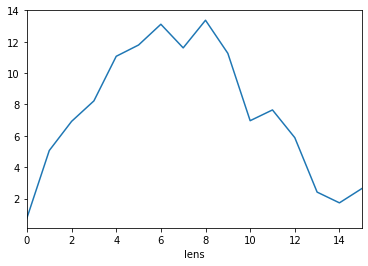

In [0]:
(df_short.groupby(['lens']).Answer.sum() / df_short.groupby(['lens']).Answer.size() * 100).plot()

In [0]:
probab = (df.groupby(['stemmed_lens']).Answer.sum() / df.groupby(['stemmed_lens']).Answer.size() * 100)

In [0]:
coef = probab / probab.sum()
coef += 1
coef

In [0]:
X

<30000x500 sparse matrix of type '<class 'numpy.float64'>'
	with 141507 stored elements in Compressed Sparse Row format>

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, stratify=y)

In [0]:
#X_train, X_test, y_train, y_test = X[:24000], X[24000:], y[:24000], y[24000:]

In [0]:
clf = LogisticRegression(dual=True, solver='liblinear', n_jobs=-1, class_weight={0: 1, 1:9}, C=0.2).fit(X, y)

In [0]:
#grid = GridSearchCV(LogisticRegression(), {})

In [0]:
y_pred = clf.predict_proba(X_test)[:, 1]
pd.Series(y_pred).head()

0    0.346235
1    0.558927
2    0.089920
3    0.313842
4    0.160127
dtype: float64

In [0]:
#for i in range(24000, 30000):
#  if (df.iloc[i, :].lens in coef.index):
#    y_pred[i - 24000] *= coef[df.iloc[i, :].lens]
#pd.Series(y_pred).head()

In [0]:
roc_auc_score(y_test, y_pred)

0.7352308491879239

In [0]:
# min_df = 15, C = 0.2, max_featers = 500, dual = True, solver = liblinear

In [0]:
#### Test data

In [0]:
test_id = pd.read_csv('test.csv')

In [75]:
test_id.shape

(11087, 1)

In [76]:
test_id.head()

,ID
0,30001
1,30002
2,30003
3,30004
4,30005


In [0]:
test_lemma = pd.read_csv('test_lemma.csv', header=None)
test_lemma["ID"] = range(30001, 30001 + 11087)

In [0]:
test_lemma.iloc[279, :]

0    279
1    NaN
Name: 279, dtype: object

In [0]:
test_lemma[test_lemma[1].isna()]

In [0]:
#data.iloc[30000 + 10331, :]

ID          40332
Question        1
Name: 40331, dtype: object

In [0]:
test = pd.merge(data, test_id)
#test = pd.merge(test, test_lemma)
#test.drop([0], axis=1, inplace=True)
#test.rename({1:'lemma'}, axis=1, inplace=True)
#test.lemma = test.lemma.fillna("")

In [78]:
test.head()

,ID,Question
0,30001,"Что в литературе обозначает слово ""эпитет""?"
1,30002,Когда отмечается ДЕНЬ ШОКОЛАДА
2,30003,Кто из этих бодибилдеров играл Халка
3,30004,"Последняя на данный момент страна, официально ..."
4,30005,Как зовут лютоволка Арьи Старк из сериала «Иг...


In [81]:
test[(test.Question.apply(lambda x: x[-1]) != '?')].shape[0] #6841 / 30000 = 0.2280,  2537 / 11087 = 0.2288

2537

In [0]:
test.shape

(11087, 2)

In [0]:
import collections

In [0]:
word_count = collections.defaultdict(int)

In [0]:
doc_cnt = test.lemma.size
for text in test.lemma:
  unique_tokens = set(text.split())
  for token in unique_tokens:
    word_count[token] += 1

In [0]:
words_from_test = set()

In [0]:
min_word_cnt, max_frequency = 3, 0.8

In [0]:
for text in test.lemma:
  for word in text.split():
    #if (word_count[word] > 3 and word_count[word] / doc_cnt < max_frequency):
    words_from_test.add(word)

In [0]:
len(words_from_test)

10892

In [0]:
test.head()

,ID,Question
0,30001,"Что в литературе обозначает слово ""эпитет""?"
1,30002,Когда отмечается ДЕНЬ ШОКОЛАДА
2,30003,Кто из этих бодибилдеров играл Халка
3,30004,"Последняя на данный момент страна, официально ..."
4,30005,Как зовут лютоволка Арьи Старк из сериала «Иг...


In [0]:
test.Question = test.apply(lambda x: regex.sub(r'[^\p{Cyrillic}\d]', ' ', x.Question.lower()), axis=1)

In [0]:
test.head()

,ID,Question
0,30001,"Что в литературе обозначает слово ""эпитет""?"
1,30002,Когда отмечается ДЕНЬ ШОКОЛАДА
2,30003,Кто из этих бодибилдеров играл Халка
3,30004,"Последняя на данный момент страна, официально ..."
4,30005,Как зовут лютоволка Арьи Старк из сериала «Иг...


In [0]:
test.Question = test.Question.apply(lambda text: ' '.join([word for word in text.split() if len(word) > 2]))

In [0]:
def stem_text(text, stemmer):
    tokens = text.split()
    return ' '.join(map(lambda w: stemmer.stem(w), tokens))

stemmed_test = []
for t in test.iloc[:, 1]:
    stemmed_test.append(stem_text(t, stemmer)) 

In [0]:
test['stemmed'] = stemmed_test

In [0]:
start = time.time()
test["lemma"] = test.iloc[:, 1].apply(lambda x: [token.lemma_ for token in nlp(x)])
# test["lemma"] = test_lemma
end = time.time()
end - start

1324.3456492424011

In [0]:
test_lemma = test["lemma"]
test_lemma.to_csv('test_lemma.csv', header=None)

In [0]:
test_lemma = test_lemma.apply(lambda x: ' '.join(x))

In [0]:
test.head()

,ID,Question,lemma
0,30001,"Что в литературе обозначает слово ""эпитет""?",что литература обозначать слово эпитет
1,30002,Когда отмечается ДЕНЬ ШОКОЛАДА,когда отмечать день шоколад
2,30003,Кто из этих бодибилдеров играл Халка,кто этот бодибилдер играть халка
3,30004,"Последняя на данный момент страна, официально ...",последний данный момент страна официально прои...
4,30005,Как зовут лютоволка Арьи Старк из сериала «Иг...,как звать лютоволка арья старк сериал игра пре...


In [0]:
test['lens'] = test.lemma.apply(lambda x: len(x.split()))

In [0]:
X_test = vectorizer.transform(test.Question)

In [0]:
X_test

<11087x500 sparse matrix of type '<class 'numpy.float64'>'
	with 52570 stored elements in Compressed Sparse Row format>

In [0]:
dim = len(vectorizer.vocabulary_)

In [0]:
y_test = clf.predict_proba(X_test)[:, 1]

In [0]:
y_test = pd.Series(y_test)

In [0]:
y_test.shape[0]

11087

In [0]:
y_test

0        0.024766
1        0.415366
2        0.671045
3        0.136201
4        0.897334
           ...   
11082    0.613275
11083    0.409743
11084    0.446423
11085    0.310142
11086    0.529930
Length: 11087, dtype: float64

In [0]:
for i in range(y_test.shape[0]):
  if (test.iloc[i, :].lens in coef.index):
    #print(test.iloc[i, :].lens, y_test[i])
    #y_test[i] = 0
  #else:
    y_test[i] *= coef[test.iloc[i, :].lens]
y_test

In [0]:
res = pd.DataFrame({'res': y_test})

In [0]:
res.index += 30001

In [0]:
res.head()

,res
30001,0.024766
30002,0.415366
30003,0.671045
30004,0.136201
30005,0.897334


In [0]:
res.to_csv('res.csv', header=None)

In [0]:
check = pd.read_csv('baseline_solution.csv', sep=';', header=None)

In [0]:
check.head()

,0
0,"30001,0.21362257117243727"
1,"30002,0.5356746442721204"
2,"30003,0.041250189683554664"
3,"30004,0.6039194442334127"
4,"30005,0.39016578818886766"


In [0]:
from tensorflow import keras
layers = keras.layers
models = keras.models

In [0]:
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
tokenize = keras.preprocessing.text.Tokenizer(num_words=500, 
                                              char_level=False)

In [0]:
tokenize.fit_on_texts(df_final.iloc[:, 4])
x_train = tokenize.texts_to_matrix(df_final.iloc[:, 4], mode='tfidf')

In [0]:
x_train.shape

(30000, 500)

In [0]:
y.shape

(30000,)

In [0]:
y[:, None].shape

(30000, 1)

In [0]:
# Check ngrams

In [0]:
mapa = set()
mapa.add('jumpy')
mapa.add('foxxy')

In [0]:
def check_tok(text):
  return [word for word in text.split() if word in mapa]

In [0]:
ngram_vectorizer = TfidfVectorizer(tokenizer=check_tok, analyzer='word', ngram_range=(1, 2))
ngram_vectorizer.fit_transform(['jumpy and foxxy', 'foxxy'])

<2x3 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [0]:
ngram_vectorizer.get_feature_names()

['foxxy', 'jumpy', 'jumpy foxxy']

In [0]:
tokenizer

In [0]:
# check finished

In [0]:
df_final.head()

,ID,Question,Answer,stemmed
0,1,как зовут лодочника реке стикс древнегреческой...,0,как зовут лодочник рек стикс древнегреческ миф...
1,2,как химии обозначается свинец,1,как хим обознача свинец
2,3,какой химический элемент преобладает составе к...,0,как химическ элемент преоблада состав камен угл
3,4,кто перечисленных был пажом времена екатерины,0,кто перечислен был паж врем екатерин
4,5,когда началась мировая война,0,когд нача миров войн


In [0]:
train_text = df_final.stemmed.apply(lambda x: x.split())
test_text = test.stemmed.apply(lambda x: x.split())

In [0]:
train_text.head()

0    [как, зовут, лодочник, рек, стикс, древнегрече...
1                         [как, хим, обознача, свинец]
2    [как, химическ, элемент, преоблада, состав, ка...
3          [кто, перечислен, был, паж, врем, екатерин]
4                            [когд, нача, миров, войн]
Name: stemmed, dtype: object

In [0]:
all_text = pd.concat([train_text,test_text], axis=0)

In [0]:
all_text.size

41087

In [0]:
word_count = collections.defaultdict(int)
doc_cnt = all_text.size
for text in all_text:
  unique_tokens = set(text)
  for token in unique_tokens:
    word_count[token] += 1

In [0]:
all_text_filtered = np.array([[word for word in text if word_count[word] > 5 and word_count[word] / all_text.size < 0.2] for text in all_text])

In [0]:
all_text[0]

0    [как, зовут, лодочник, рек, стикс, древнегрече...
0             [что, литератур, обознача, слов, эпитет]
Name: stemmed, dtype: object

In [0]:
all_text_filtered[30000]

['что', 'литератур', 'обознача', 'слов']

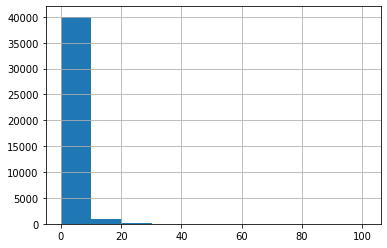

In [0]:
pd.Series(all_text_filtered).apply(len).hist()

In [0]:
train_text_filtered = all_text_filtered[:30000]

In [0]:
df_final['ttf'] = train_text_filtered

In [0]:
df_final['ttf_len'] = df_final.ttf.apply(len)

In [0]:
df_final[df_final.ttf_len > 10].Answer.sum() / df_final[df_final.ttf_len > 10].shape[0] * 100

3.6601307189542487

In [0]:
df_final.Answer.sum() / df_final.shape[0] * 100

10.386666666666667

In [0]:
df_final.head()

,ID,Question,Answer,lens,ttf,ttf_len,stemmed
0,1,как зовут лодочника реке стикс древнегреческой...,0,62,"[зовут, рек, древнегреческ, мифолог]",4,как зовут лодочник рек стикс древнегреческ миф...
1,2,как химии обозначается свинец,1,32,"[хим, обознача]",2,как хим обознача свинец
2,3,какой химический элемент преобладает составе к...,0,62,"[химическ, элемент, преоблада, состав, камен, ...",6,как химическ элемент преоблада состав камен угл
3,4,кто перечисленных был пажом времена екатерины,0,55,"[кто, перечислен, был, врем, екатерин]",5,кто перечислен был паж врем екатерин
4,5,когда началась мировая война,0,31,"[когд, нача, миров, войн]",4,когд нача миров войн


In [0]:
dim = 50

In [0]:
model = word2vec.Word2Vec(all_text, size=50, window=3, workers=-1)

In [0]:
pd.Series(model.wv.index2word).size

5145

In [0]:
# wv - dict from word to it's emmbading
#model.wv['какой']

In [0]:
# dict(zip(model.wv.index2word, model.wv.syn0))

In [0]:
transformed_data = np.array([
            np.mean([model.wv[w] for w in words if w in model.wv] 
                    or [np.zeros(dim)], axis=0)
            for words in train_text
        ])

In [0]:
transformed_data.shape

(30000, 50)

In [0]:
# DOTO change delete words
cnt = 0
for text in train_text:
  for word in text:
    if word not in model.wv:
      cnt += 1
cnt, train_text.shape

(0, (30000,))

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
y = df_final.Answer
#transformed_data = pd.Series(transformed_data)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(transformed_data, y, test_size=0.2, random_state=42, stratify=y)

In [0]:
X_train.shape[1]

300

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from tensorflow.keras.metrics import AUC

Using TensorFlow backend.


In [0]:
model = Sequential()
model.add(Dense(512, input_dim=(1692)))
model.add(Activation('tanh'))
#model.add(Dropout(0.1))
model.add(Activation('tanh'))
model.add(Dense(256))
#model.add(Dropout(0.1))
model.add(Activation('tanh'))
model.add(Dense(128))
#model.add(Dropout(0.1))
model.add(Activation('tanh'))
model.add(Dense(64))
#model.add(Dropout(0.1))
model.add(Activation('tanh'))
model.add(Dense(32))
#model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_crossentropy'])

In [0]:
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    class_weight={0:1, 1:9},
                    verbose=0)

In [0]:
classes = model.predict_proba(X_test, batch_size=128)
roc_auc_score(y_test, classes)

0.6760048372011938

In [0]:
500 -> 128 -> 64 -> 32 -> 16 -> 1
tanh * 4, sig 0.7439

In [0]:
# XGBoost

In [0]:
import xgboost as xgb

In [0]:
dtr = xgb.DMatrix(X_train, label=y_train, missing = np.nan)
dval = xgb.DMatrix(X_test, label= y_test,missing = np.nan)
watchlist = [(dtr, 'train'), (dval, 'eval')]
history = dict()

In [0]:
1 / y_test.mean()

9.630818619582664

In [0]:
params = {
    'max_depth': 7,
    'eta': 0.025,
    'nthread':-1,
    'gamma' : 1,
    'alpha' : 1,
    'subsample': 1,
    'eval_metric': ['auc'],
    'objective': 'binary:logistic',
    'colsample_bytree': 0.9,
    'min_child_weight': 20,
    'scale_pos_weight':9,
    'seed':7
} #max_depth - 10, min_child_weight = 25 72.46

In [0]:
model_new = xgb.train(params, dtr, num_boost_round=200, evals=watchlist, evals_result=history, verbose_eval=20)

[0]	train-auc:0.663426	eval-auc:0.650869
[20]	train-auc:0.709518	eval-auc:0.686014
[40]	train-auc:0.722268	eval-auc:0.693666
[60]	train-auc:0.732793	eval-auc:0.701369
[80]	train-auc:0.740881	eval-auc:0.707199
[100]	train-auc:0.749294	eval-auc:0.711506
[120]	train-auc:0.753352	eval-auc:0.712191
[140]	train-auc:0.757483	eval-auc:0.714327
[160]	train-auc:0.759548	eval-auc:0.715724
[180]	train-auc:0.762737	eval-auc:0.718408
[199]	train-auc:0.765299	eval-auc:0.718425


In [0]:
dfnow = pd.read_csv('res73.csv', header=None)
dfwas = pd.read_csv('res64.csv', header=None)

In [0]:
dfnow.drop([0], inplace=True, axis=1)

In [0]:
dfnow= dfnow.rename({1: 'res_now'}, axis=1)

In [106]:
dfnow.head()

,res_now
0,0.006402
1,0.412673
2,0.700921
3,0.049069
4,0.908883


In [107]:
dfwas.head()

,0,1
0,30001,0.413396
1,30002,0.244051
2,30003,0.451170
3,30004,0.083641
4,30005,0.712161


In [0]:
df = dfwas.rename({1:'res_was'}, axis=1)
df['res_now'] = dfnow.res_now

In [109]:
df.head()

,0,res_was,res_now
0,30001,0.413396,0.006402
1,30002,0.244051,0.412673
2,30003,0.451170,0.700921
3,30004,0.083641,0.049069
4,30005,0.712161,0.908883


In [38]:
df[(abs(df.res_was - df.res_now) > 0.5) ] #& (((df.res_now < 0.2) & (df.res_was < 0.2)) | (df.res_now > 0.8))

,0,res_was,res_now
15,30016,0.098970,0.836211
18,30019,0.681288,0.014852
20,30021,0.675420,0.022460
36,30037,0.717411,0.050203
39,30040,0.718911,0.166853
...,...,...,...
10975,40976,0.680894,0.014477
11015,41016,0.743724,0.197289
11048,41049,0.374856,0.945689
11050,41051,0.767336,0.201466


In [59]:
df[new_res != df.res_now]

,0,res_was,res_now,new_res
15,30016,0.098970,0.836211,1.0
18,30019,0.681288,0.014852,0.0
20,30021,0.675420,0.022460,0.0
36,30037,0.717411,0.050203,0.0
39,30040,0.718911,0.166853,0.0
...,...,...,...,...
10975,40976,0.680894,0.014477,0.0
11015,41016,0.743724,0.197289,0.0
11048,41049,0.374856,0.945689,1.0
11050,41051,0.767336,0.201466,0.0


In [0]:
new_res = df.apply(lambda x: round(x.res_now) if abs(x.res_was - x.res_now) > 0.5 else x.res_now, axis=1)

In [0]:
df['new_res'] = new_res

In [0]:
res = pd.DataFrame({'res': new_res})
res.index += 30001

In [0]:
res.to_csv('kek.csv', header=None)